In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from sentence_transformers import SentenceTransformer

from transformers import AutoModelForSequenceClassification,  AutoTokenizer, AutoModelForMaskedLM
from transformers import RobertaTokenizerFast, EncoderDecoderModel, pipeline

import torch



### doctissimo dataset

In [51]:
df1 = pd.read_csv('/Users/tchouar/Desktop/LLM/data/Doctissimo_forum.csv')
df1.shape

(209152, 4)

In [52]:
df1.head(2)

,Title,Author,Date,Content
0,Qui peut m'éclairer sur résultats TSH ?,fanny000,2024-05-03 17:06:18,"Bonjour,Suite à un bilan sanguin, mon taux de ..."
1,Qui peut m'éclairer sur résultats TSH ?,petitbouchon,2024-05-03 15:33:16,"Bonjour,Comme vous pouvez le constater, votre ..."


In [53]:
df1 = df1['Content']

### carenity_dataset

In [54]:
df2 = pd.read_csv('data/carenity_df.csv')
df2.shape

(480, 3)

In [55]:
df2.head(2)

,dates,auteur,message
0,26/04/2019 16:54,NaN,@Rochambeau coucou 😉Alors au début j'avais l'a...
1,27/04/2019 11:46,NaN,"Bonjour @ainsival‍ ! moi, on m'a fait essayer ..."


In [56]:
df2 = df2['message']

### dataset 

In [57]:
df3 = pd.read_csv('/Users/tchouar/Desktop/LLM/data/data.csv')
df3.shape

/var/folders/87/c96z3lj528s0yqr3y568z9qr0000gn/T/ipykernel_32357/3279214680.py:1: DtypeWarning: Columns (7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('/Users/tchouar/Desktop/LLM/data/data.csv')


(122471, 74)

In [58]:
df3.head(3)

,level_0,index,forumName,topicName,postTimestamp,postUser,textPostContent,super_user,etranger,adherant,...,insomnie,palpitation,hypersudation,ganglion,calvitie,douleurs articulaires,douleurs musculaires,acouphene,vertige,congenital
0,0,0,Basedow,"Important : FAQ : La maladie de Basedow, c'es...",2008-12-17,Beate,La maladie de Basedow Basedow est une maladi...,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,1,1,Basedow,Basedow: Sautes d'humeur et état dépressif,2020-12-09,bend57,"Bonjour à vous, Je découvre un peu cette ma...",NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2,2,2,Basedow,Baisse T3 avec alimentation cétogène ?,2019-11-02,lelene4,Bonjour Je pratique l'alimentation cétogène...,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [59]:
df3 = df3['textPostContent']

In [60]:
df3.head()

0    La maladie de Basedow   Basedow est une maladi...
1    Bonjour à vous,    Je découvre un peu cette ma...
2    Bonjour    Je pratique l'alimentation cétogène...
3    bonjour a toutes et tous je suis avec ma femme...
4    Bonjour,    Je me présente, je suis un jeune h...
Name: textPostContent, dtype: object

In [61]:
df = pd.concat([df1,df2, df3], ignore_index=True)

In [62]:
df.shape

(332103,)

In [63]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)

In [64]:
shuffled_df = shuffled_df.to_frame()

In [65]:
# suppression des backslashes sur chaque cellule du DataFrame
shuffled_df = shuffled_df.applymap(lambda x: x.replace('\\', '') if isinstance(x, str) else x)

/var/folders/87/c96z3lj528s0yqr3y568z9qr0000gn/T/ipykernel_32357/1491739499.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shuffled_df = shuffled_df.applymap(lambda x: x.replace('\\', '') if isinstance(x, str) else x)


In [67]:
dataframe = shuffled_df.head(20000)

In [68]:
dataframe.rename(columns={0: 'posts'}, inplace=True)

/var/folders/87/c96z3lj528s0yqr3y568z9qr0000gn/T/ipykernel_32357/1311089294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.rename(columns={0: 'posts'}, inplace=True)


In [69]:
dataframe.shape

(20000, 1)

In [71]:
dataframe = dataframe.dropna()

In [72]:
dataframe = dataframe.reset_index(drop=True)

### partie LLM

In [73]:
## import the model for text summarization 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = 'mrm8488/camembert2camembert_shared-finetuned-french-summarization'
tokenizer = RobertaTokenizerFast.from_pretrained(ckpt)
model = EncoderDecoderModel.from_pretrained(ckpt).to(device)

The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [74]:
# function that generats summary 
def generate_summary(text):
   inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
   input_ids = inputs.input_ids.to(device)
   attention_mask = inputs.attention_mask.to(device)
   output = model.generate(input_ids, attention_mask=attention_mask)
   return tokenizer.decode(output[0], skip_special_tokens=True)
   


In [75]:
#  initialisation of the DistillCamembert 'sentiment analysis'
analyzer = pipeline(
    task='text-classification',
    model="cmarkea/distilcamembert-base-sentiment",
    tokenizer="cmarkea/distilcamembert-base-sentiment"
)

In [97]:
nmbr_sum = 0
def analyze_post(post, idx):
    global nmbr_sum 
    try:
        if len(tokenizer.tokenize(post)) > 512:
            print(f'Post number {idx} is too long, summarizing...')
            nmbr_sum += 1
            summary = generate_summary(post)
            sentiment = analyzer(summary)
        else:
            sentiment = analyzer(post)
        return sentiment[0]['label']
    except Exception as e:
        print(f'Error at post number {idx}: {e}')
        return None

In [98]:


sentiments = []
for idx, post in enumerate(dataframe['posts']):
    print(f'Processing post number {idx}...')
    sentiment = analyze_post(post, idx)
    if sentiment is not None:
        sentiments.append(sentiment)
    else:
        sentiments.append('Error')

dataframe['sentiments'] = sentiments

Processing post number 0...
Processing post number 1...
Processing post number 2...
Processing post number 3...
Processing post number 4...
Processing post number 5...
Processing post number 6...
Processing post number 7...
Processing post number 8...
Processing post number 9...
Processing post number 10...
Processing post number 11...
Processing post number 12...
Processing post number 13...
Processing post number 14...
Processing post number 15...
Processing post number 16...
Processing post number 17...
Processing post number 18...
Processing post number 19...
Processing post number 20...
Processing post number 21...
Processing post number 22...
Processing post number 23...
Processing post number 24...
Processing post number 25...
Processing post number 26...
Processing post number 27...
Processing post number 28...
Processing post number 29...
Processing post number 30...
Processing post number 31...
Processing post number 32...
Processing post number 33...
Processing post number 3

Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


Processing post number 1758...
Processing post number 1759...
Processing post number 1760...
Processing post number 1761...
Error at post number 1761: index out of range in self
Processing post number 1762...
Processing post number 1763...
Processing post number 1764...
Processing post number 1765...
Processing post number 1766...
Processing post number 1767...
Processing post number 1768...
Processing post number 1769...
Processing post number 1770...
Processing post number 1771...
Processing post number 1772...
Processing post number 1773...
Processing post number 1774...
Processing post number 1775...
Processing post number 1776...
Processing post number 1777...
Processing post number 1778...
Processing post number 1779...
Processing post number 1780...
Processing post number 1781...
Processing post number 1782...
Processing post number 1783...
Processing post number 1784...
Processing post number 1785...
Processing post number 1786...
Processing post number 1787...
Processing post 

In [118]:
# Simplification des prédictions de notre LLM
final_sentiments = []
for sentiment in sentiments:
    if sentiment == '5 stars' or  sentiment == '4 stars':
        final_sentiments.append('Positif')
    elif  sentiment == '2 stars' or  sentiment == '1 star':
        final_sentiments.append('Négatif')
    elif  sentiment == '3 stars' :
        final_sentiments.append('Neutre')

/var/folders/87/c96z3lj528s0yqr3y568z9qr0000gn/T/ipykernel_32357/3820813406.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Catégorie', y='Nombre', data=data, palette='rocket')


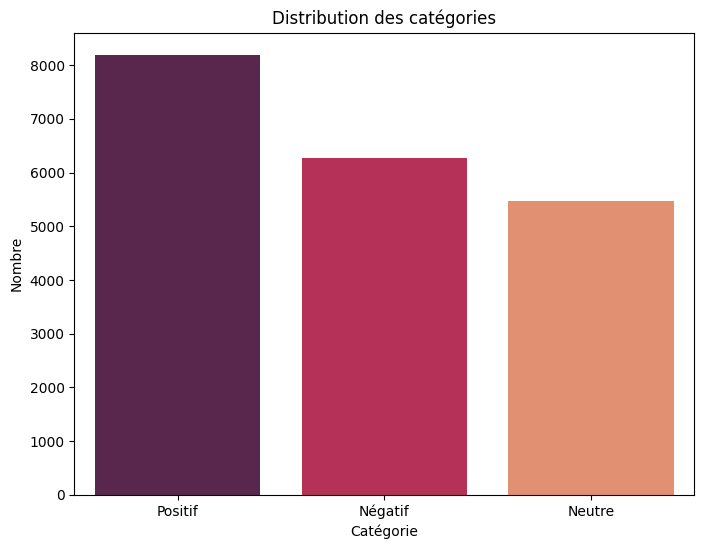

In [123]:
# Compter les occurrences de chaque catégorie
data = pd.Series(final_sentiments).value_counts().reset_index()
data.columns = ['Catégorie', 'Nombre']


plt.figure(figsize=(8, 6))
sns.barplot(x='Catégorie', y='Nombre', data=data, palette='rocket')


plt.xlabel('Catégorie')
plt.ylabel('Nombre')
plt.title('Distribution des catégories')


plt.show()